In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class EMABacktester(): 
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Daily_nifty_data.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1] 
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1] 
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimazation algorithm).
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [3]:
tester = EMABacktester("Nifty50", 50, 200, "2008-01-01", "2022-07-01", 0.0004)

In [4]:
tester

EMABacktester(symbol = Nifty50, EMA_S = 50, EMA_L = 200, start = 2008-01-01, end = 2022-07-01)

In [5]:
tester.test_strategy()

(0.939706, -3.93842)

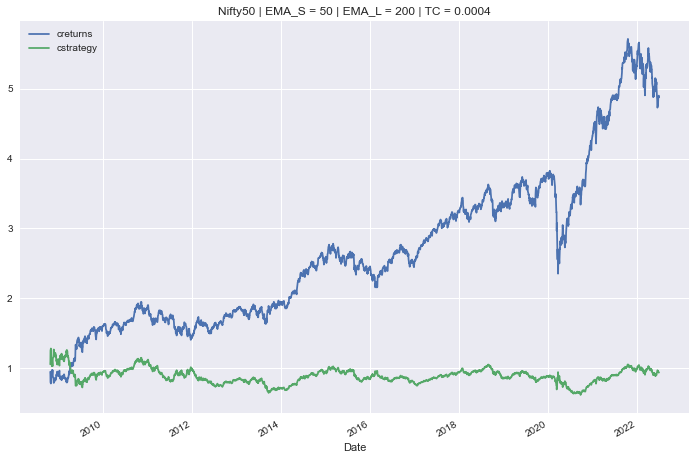

In [6]:
tester.plot_results()

In [7]:
tester.optimize_parameters((10, 50, 1), (51, 200, 1))

(array([14., 65.]), 4.59801)

In [8]:
tester.test_strategy()

(4.59801, 1.290891)

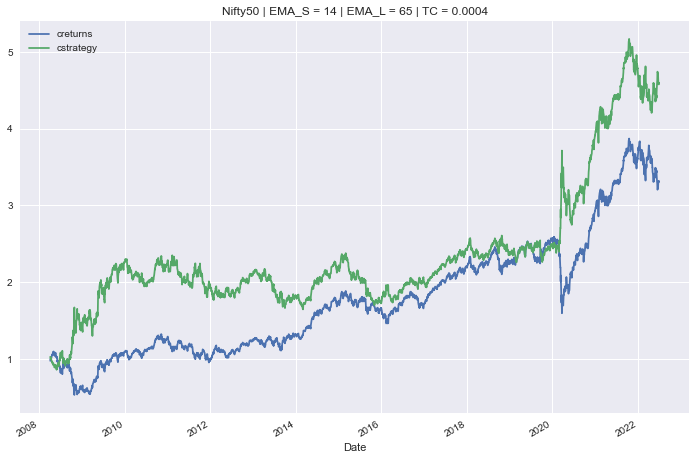

In [9]:
tester.plot_results()